In [25]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Concatenate, Attention, GlobalAveragePooling1D, MultiHeadAttention, LayerNormalization, Add)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [26]:
def load_legal_datasets(folder_path):
    """
    Loads all CSVs from the given folder into a single DataFrame.
    Each file represents a different clause category.
    """
    all_data = []
    
    #Checking if the path exists before trying to list files
    if not os.path.exists(folder_path):
        print(f"Error: Path not found - {folder_path}")
        return pd.DataFrame() 
        
    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            path = os.path.join(folder_path, file)
            try:
                df = pd.read_csv(path)
                df['category'] = file.replace('.csv', '') 
                all_data.append(df)
            except Exception as e:
                print(f"Error loading {file}: {e}")
                
    if not all_data:
        print("No CSV files were loaded. Check the folder path and file contents.")
        return pd.DataFrame()

    return pd.concat(all_data, ignore_index=True)

#Loading the datasets
dataset_folder_path = 'datasets/'
data = load_legal_datasets(dataset_folder_path)

if not data.empty:
    print("Total clauses loaded:", len(data))
    print("\nClause Categories Loaded:")
    print(data['category'].value_counts())

Total clauses loaded: 150881

Clause Categories Loaded:
category
time-of-essence                           630
time-of-the-essence                       620
definitions-and-interpretation            590
capitalized-terms                         590
captions                                  580
                                         ... 
tax-returns                               140
trustee-may-file-proofs-of-claim          132
fees_royalties                            123
marketing                                  48
standard-terms-and-conditions-of-trust     15
Name: count, Length: 395, dtype: int64


In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150881 entries, 0 to 150880
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   clause_text  150881 non-null  object
 1   clause_type  150881 non-null  object
 2   category     150881 non-null  object
dtypes: object(3)
memory usage: 3.5+ MB


In [28]:
data.head()

,clause_text,clause_type,category
0,Absence of Certain Changes or Events. Except a...,absence-of-certain-changes-or-events,absence-of-certain-changes-or-events
1,Absence of Certain Changes or Events. Since Ma...,absence-of-certain-changes-or-events,absence-of-certain-changes-or-events
2,Absence of Certain Changes or Events. (a) Sinc...,absence-of-certain-changes-or-events,absence-of-certain-changes-or-events
3,Absence of Certain Changes or Events. Since th...,absence-of-certain-changes-or-events,absence-of-certain-changes-or-events
4,Absence of Certain Changes or Events. Except a...,absence-of-certain-changes-or-events,absence-of-certain-changes-or-events


In [29]:
def clean_text(text):
    """
    Cleans and normalizes a single text string.

    Steps:
    1. Lowercasing
    2. Remove punctuation, numbers, and special characters
    3. Tokenize
    4. Remove stopwords
    5. Lemmatize
    """
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = text.lower()

    # Remove punctuation, digits, and non-alphabetic characters
    text = re.sub(r'[^a-z\s]', ' ', text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords and very short tokens
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Rejoin cleaned tokens
    cleaned_text = ' '.join(tokens)
    return cleaned_text

In [30]:
def preprocess_dataset(df, text_column='clause_text'):
    """
    Applies text cleaning to all entries in the given column of the DataFrame.
    
    Args:
        df (pd.DataFrame): Data containing legal clauses
        text_column (str): Column name containing clause text
        
    Returns:
        pd.DataFrame: DataFrame with a new column 'cleaned_text'
    """
    if text_column not in df.columns:
        raise ValueError(f"Column '{text_column}' not found in DataFrame.")
    
    print("Starting text preprocessing...")
    df['cleaned_text'] = df[text_column].apply(clean_text)
    print("Preprocessing complete ✅")

    # Display a few examples
    print("\nSample cleaned clauses:")
    print(df[[text_column, 'cleaned_text']].head())

    return df

In [31]:
data = preprocess_dataset(data, text_column='clause_text')

Starting text preprocessing...
Preprocessing complete ✅

Sample cleaned clauses:
                                         clause_text  \
0  Absence of Certain Changes or Events. Except a...   
1  Absence of Certain Changes or Events. Since Ma...   
2  Absence of Certain Changes or Events. (a) Sinc...   
3  Absence of Certain Changes or Events. Since th...   
4  Absence of Certain Changes or Events. Except a...   

                                        cleaned_text  
0  absence certain change event except set forth ...  
1  absence certain change event since march excep...  
2  absence certain change event since december ev...  
3  absence certain change event since date compan...  
4  absence certain change event except set forth ...  


In [32]:
data['cleaned_text']

0         absence certain change event except set forth ...
1         absence certain change event since march excep...
2         absence certain change event since december ev...
3         absence certain change event since date compan...
4         absence certain change event except set forth ...
                                ...                        
150876    witnesseth consideration mutual covenant promi...
150877    witnesseth consideration mutual covenant agree...
150878    witnesseth village developer entered agreement...
150879    witnesseth consideration covenant agreement re...
150880    witnesseth consideration rent covenant conditi...
Name: cleaned_text, Length: 150881, dtype: object

In [33]:
def create_clause_pairs(df, text_col='cleaned_text', category_col='category', max_pairs=50000):
    """
    Fast version of clause pair generation using vectorized operations.
    
    Creates positive (same category) and negative (different category) clause pairs efficiently.

    Args:
        df (pd.DataFrame): Dataset containing cleaned clauses and categories.
        text_col (str): Name of text column.
        category_col (str): Name of category column.
        max_pairs (int): Total number of pairs to generate.

    Returns:
        pd.DataFrame: DataFrame with columns ['clause1', 'clause2', 'label']
    """
    random.seed(42)
    np.random.seed(42)

    # Group all clauses by category once (avoid repeated filtering)
    grouped = df.groupby(category_col)[text_col].apply(list).to_dict()
    categories = list(grouped.keys())

    pos_pairs = []
    neg_pairs = []

    # Estimate number of pairs per category based on available total
    per_cat_limit = max_pairs // (2 * len(categories)) + 1

    # Generate positive pairs (same category)
    for cat, clauses in grouped.items():
        if len(clauses) < 2:
            continue
        n = min(per_cat_limit, len(clauses) - 1)
        idx = np.random.choice(len(clauses), size=(n, 2), replace=True)
        for i, j in idx:
            if i != j:
                pos_pairs.append((clauses[i], clauses[j], 1))
        if len(pos_pairs) >= max_pairs // 2:
            break

    # Generate negative pairs (different categories)
    total_needed = max_pairs - len(pos_pairs)
    while len(neg_pairs) < total_needed:
        cat1, cat2 = np.random.choice(categories, 2, replace=False)
        c1_list, c2_list = grouped[cat1], grouped[cat2]
        i1 = np.random.randint(0, len(c1_list))
        i2 = np.random.randint(0, len(c2_list))
        neg_pairs.append((c1_list[i1], c2_list[i2], 0))

    # Combine and shuffle once
    all_pairs = np.array(pos_pairs + neg_pairs, dtype=object)
    np.random.shuffle(all_pairs)

    pairs_df = pd.DataFrame(all_pairs, columns=['clause1', 'clause2', 'label'])

    print(f"Generated {len(pairs_df)} clause pairs "
          f"({len(pos_pairs)} positive, {len(neg_pairs)} negative).")

    return pairs_df

In [34]:
pairs_df = create_clause_pairs(data)

print(pairs_df.head())

Generated 50000 clause pairs (25006 positive, 24994 negative).
                                             clause1  \
0  representation warranty party hereto represent...   
1  submission jurisdiction party submits jurisdic...   
2  notice claiming indemnification hereunder inde...   
3  provision neither terminal operator user may s...   
4  therefore consideration premise mutual covenan...   

                                             clause2 label  
0  caption heading caption hereof convenience sha...     0  
1  submission jurisdiction guarantor hereby irrev...     1  
2  duration agreement agreement effective date se...     0  
3  provision purpose resolution term date issuanc...     1  
4  undertaking cost party indenture agree holder ...     0  


In [35]:
def tokenize_and_pad(pairs_df, max_vocab=20000, max_len=150):
    """
    Tokenizes both clause1 and clause2 and pads them to equal length.
    Returns padded sequences and tokenizer.
    """

    print("Fitting tokenizer on all text...")
    all_text = list(pairs_df['clause1']) + list(pairs_df['clause2'])

    tokenizer = Tokenizer(num_words=max_vocab, oov_token="<OOV>")
    tokenizer.fit_on_texts(all_text)

    # Convert text to sequences
    seq1 = tokenizer.texts_to_sequences(pairs_df['clause1'])
    seq2 = tokenizer.texts_to_sequences(pairs_df['clause2'])

    # Pad sequences
    X1 = pad_sequences(seq1, maxlen=max_len, padding='post', truncating='post')
    X2 = pad_sequences(seq2, maxlen=max_len, padding='post', truncating='post')
    
    y = pairs_df['label'].astype(int).values

    print("Tokenization & Padding complete!")
    print("Vocabulary size:", min(max_vocab, len(tokenizer.word_index)))

    return X1, X2, y, tokenizer



In [36]:
max_vocab = 20000
max_len = 150

X1, X2, y, tokenizer = tokenize_and_pad(pairs_df, max_vocab=max_vocab, max_len=max_len)

Fitting tokenizer on all text...
Tokenization & Padding complete!
Vocabulary size: 20000


In [37]:
#Train Split
def split_dataset(X1, X2, y, test_size=0.2, val_size=0.1):
    X1_train, X1_temp, X2_train, X2_temp, y_train, y_temp = train_test_split(X1, X2, y, test_size=test_size, random_state=42)

    val_relative = val_size / (1 - test_size)

    X1_val, X1_test, X2_val, X2_test, y_val, y_test = train_test_split(X1_temp, X2_temp, y_temp, test_size=val_relative, random_state=42)

    print("Dataset split:")
    print("Train:", len(y_train))
    print("Val:", len(y_val))
    print("Test:", len(y_test))

    return (X1_train, X2_train, y_train, X1_val, X2_val, y_val, X1_test, X2_test, y_test)

In [38]:
(X1_train, X2_train, y_train, X1_val, X2_val, y_val, X1_test, X2_test, y_test) = split_dataset(X1, X2, y, test_size=0.20, val_size=0.10)

Dataset split:
Train: 40000
Val: 8750
Test: 1250


In [46]:
def build_bilstm_model(
    tokenizer=None,
    max_vocab=20000,
    embedding_dim=128,
    max_len=150,
    lstm_units=64,
    share_weights=True,
    learning_rate=1e-3
):
    """
    Builds a siamese BiLSTM model for clause-pair similarity.
    If `tokenizer` is provided, the embedding input_dim is set from it
    (min(max_vocab, vocab_size+1)). Otherwise `max_vocab` is used.

    Params:
        tokenizer: (optional) fitted keras.preprocessing.text.Tokenizer
        max_vocab: fallback maximum vocab size (int)
        embedding_dim: embedding vector size
        max_len: input sequence length
        lstm_units: hidden units for LSTM (per direction)
        share_weights: if True (default) reuse same BiLSTM for both inputs
        learning_rate: Adam learning rate

    Returns:
        compiled Keras Model
    """
    # Determine embedding input dimension
    if tokenizer is not None:
        # +1 for padding / reserved index
        vocab_size = min(max_vocab, len(tokenizer.word_index) + 1)
    else:
        vocab_size = max_vocab

    # Inputs
    input1 = Input(shape=(max_len,), name="clause1")
    input2 = Input(shape=(max_len,), name="clause2")

    # Shared embedding (mask_zero helps LSTM ignore padded zeros)
    embedding = Embedding(input_dim=vocab_size,
                          output_dim=embedding_dim,
                          input_length=max_len,
                          mask_zero=True,
                          name="embedding")

    e1 = embedding(input1)
    e2 = embedding(input2)

    # LSTM layers (shared or separate)
    if share_weights:
        # Shared BiLSTM layer (siamese)
        bi_lstm = Bidirectional(LSTM(lstm_units, return_sequences=False), name="bilstm_shared")
        v1 = bi_lstm(e1)
        v2 = bi_lstm(e2)
    else:
        # Separate BiLSTM layers (no weight sharing)
        bi_lstm1 = Bidirectional(LSTM(lstm_units, return_sequences=False), name="bilstm_1")
        bi_lstm2 = Bidirectional(LSTM(lstm_units, return_sequences=False), name="bilstm_2")
        v1 = bi_lstm1(e1)
        v2 = bi_lstm2(e2)

    # Combine and classify
    merged = Concatenate(name="concat")([v1, v2])
    x = Dense(64, activation="relu", name="dense_64")(merged)
    x = Dense(32, activation="relu", name="dense_32")(x)
    out = Dense(1, activation="sigmoid", name="output")(x)

    model = Model(inputs=[input1, input2], outputs=out, name="BiLSTM_siamese")

    # Compile with extra useful metrics for binary similarity
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            tf.keras.metrics.Precision(name="precision"),
            tf.keras.metrics.Recall(name="recall"),
            tf.keras.metrics.AUC(name="auc")
        ]
    )

    return model

In [47]:
# assume: tokenizer, X1_train, X2_train, y_train, X1_val, X2_val, y_val already exist
model = build_bilstm_model(tokenizer=tokenizer, max_len=max_len)
model.summary()

# callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor="val_auc", patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_bilstm.keras", save_best_only=True, monitor="val_auc")
]

history = model.fit(
    [X1_train, X2_train],
    y_train,
    validation_data=([X1_val, X2_val], y_val),
    epochs=10,
    batch_size=64,
    callbacks=callbacks
)


C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "BiLSTM_siamese"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ clause1 (InputLayer)          │ (None, 150)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ clause2 (InputLayer)          │ (None, 150)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding (Embedding)         │ (None, 150, 128)          │       2,560,000 │ clause1[0][0],             │
│                               │                           │                 │ clause2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_14 (NotEqual)       │ (None, 150)               │               0 │ clause1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_15 (NotEqual)       │ (None, 150)               │               0 │ clause2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bilstm_shared (Bidirectional) │ (None, 128)               │          98,816 │ embedding[0][0],           │
│                               │                           │                 │ not_equal_14[0][0],        │
│                               │                           │                 │ embedding[1][0],           │
│                               │                           │                 │ not_equal_15[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concat (Concatenate)          │ (None, 256)               │               0 │ bilstm_shared[0][0],       │
│                               │                           │                 │ bilstm_shared[1][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_64 (Dense)              │ (None, 64)                │          16,448 │ concat[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_32 (Dense)              │ (None, 32)                │           2,080 │ dense_64[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ output (Dense)                │ (None, 1)                 │              33 │ dense_32[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,677,377 (10.21 MB)

 Trainable params: 2,677,377 (10.21 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['clause1', 'clause2']. Received: the structure of inputs=('*', '*')
  warnings.warn(


625/625 ━━━━━━━━━━━━━━━━━━━━ 130s 201ms/step - accuracy: 0.7097 - auc: 0.7879 - loss: 0.4816 - precision: 0.6887 - recall: 0.7749 - val_accuracy: 0.9553 - val_auc: 0.9893 - val_loss: 0.1246 - val_precision: 0.9225 - val_recall: 0.9938
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 133s 212ms/step - accuracy: 0.9681 - auc: 0.9910 - loss: 0.1034 - precision: 0.9481 - recall: 0.9904 - val_accuracy: 0.9698 - val_auc: 0.9932 - val_loss: 0.0934 - val_precision: 0.9479 - val_recall: 0.9940
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 135s 215ms/step - accuracy: 0.9772 - auc: 0.9935 - loss: 0.0810 - precision: 0.9644 - recall: 0.9909 - val_accuracy: 0.9769 - val_auc: 0.9919 - val_loss: 0.0853 - val_precision: 0.9630 - val_recall: 0.9917
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 129s 206ms/step - accuracy: 0.9824 - auc: 0.9960 - loss: 0.0607 - precision: 0.9731 - recall: 0.9925 - val_accuracy: 0.9751 - val_auc: 0.9946 - val_loss: 0.0848 - val_precision: 0.9778 - val_recall: 0.9720
Epoch 5/10
625/625 ━━━━━━━━

In [39]:
def build_attention_model(max_len=150, max_vocab=20000, embedding_dim=128, learning_rate=1e-3):
    """
    Transformer-style Attention Encoder model (compatible with BiLSTM pipeline).
    """
    # Inputs
    inp1 = Input(shape=(max_len,), name="clause1")
    inp2 = Input(shape=(max_len,), name="clause2")

    # Shared Embedding
    embedding = Embedding(input_dim=max_vocab, output_dim=embedding_dim, input_length=max_len, mask_zero=True)
    enc1 = embedding(inp1)
    enc2 = embedding(inp2)

    # Multi-Head Self-Attention for each clause
    attn = MultiHeadAttention(num_heads=4, key_dim=embedding_dim)

    # Apply attention independently to each clause
    attn_out1 = attn(enc1, enc1)
    attn_out2 = attn(enc2, enc2)

    # Residual connection + Layer normalization
    out1 = LayerNormalization(epsilon=1e-6)(Add()([enc1, attn_out1]))
    out2 = LayerNormalization(epsilon=1e-6)(Add()([enc2, attn_out2]))

    # Global pooling to reduce sequence dimension
    pooled1 = GlobalAveragePooling1D()(out1)
    pooled2 = GlobalAveragePooling1D()(out2)

    # Combine both encoded clause vectors
    merged = tf.keras.layers.Concatenate()([pooled1, pooled2])

    # Classification layers
    x = Dense(128, activation='relu')(merged)
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)
    out = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[inp1, inp2], outputs=out, name="Attention_Encoder")

    model.compile(
        optimizer=Adam(learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
    )

    return model

In [40]:
attn_model = build_attention_model(max_len=150, max_vocab=20000)
print(attn_model.summary())

history2 = attn_model.fit(
    [X1_train, X2_train], y_train,
    validation_data=([X1_val, X2_val], y_val),
    epochs=10,
    batch_size=32
)

C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "Attention_Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ clause1 (InputLayer)          │ (None, 150)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ clause2 (InputLayer)          │ (None, 150)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_8 (Embedding)       │ (None, 150, 128)          │       2,560,000 │ clause1[0][0],             │
│                               │                           │                 │ clause2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_12 (NotEqual)       │ (None, 150)               │               0 │ clause1[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ not_equal_13 (NotEqual)       │ (None, 150)               │               0 │ clause2[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ multi_head_attention_5        │ (None, 150, 128)          │         263,808 │ embedding_8[0][0],         │
│ (MultiHeadAttention)          │                           │                 │ embedding_8[0][0],         │
│                               │                           │                 │ not_equal_12[0][0],        │
│                               │                           │                 │ not_equal_12[0][0],        │
│                               │                           │                 │ embedding_8[1][0],         │
│                               │                           │                 │ embedding_8[1][0],         │
│                               │                           │                 │ not_equal_13[0][0],        │
│                               │                           │                 │ not_equal_13[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_10 (Add)                  │ (None, 150, 128)          │               0 │ embedding_8[0][0],         │
│                               │                           │                 │ multi_head_attention_5[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_11 (Add)                  │ (None, 150, 128)          │               0 │ embedding_8[1][0],         │
│                               │                           │                 │ multi_head_attention_5[1]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_10        │ (None, 150, 128)          │             256 │ add_10[0][0]               │
│ (LayerNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ logical_or_2 (LogicalOr)      │ (None, 150)               │               0 │ not_equal_12[0][0],        │
│                               │                           │                 │ not_equal_12[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ layer_normalization_11        │ (None, 150, 128)          │             256 │ add_11[0][0]               │
│ (LayerNormalization)          │                           │               

 Total params: 2,865,537 (10.93 MB)

 Trainable params: 2,865,537 (10.93 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['clause1', 'clause2']. Received: the structure of inputs=('*', '*')
  warnings.warn(
C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\layer.py:932: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
C:\Users\DELL\AppData\Local

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 220s 173ms/step - accuracy: 0.5992 - auc_1: 0.6495 - loss: 0.6396 - precision_1: 0.5926 - recall_1: 0.6325 - val_accuracy: 0.7807 - val_auc_1: 0.8530 - val_loss: 0.4707 - val_precision_1: 0.7484 - val_recall_1: 0.8433
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 215s 172ms/step - accuracy: 0.8240 - auc_1: 0.8958 - loss: 0.4038 - precision_1: 0.8019 - recall_1: 0.8555 - val_accuracy: 0.8111 - val_auc_1: 0.8874 - val_loss: 0.4187 - val_precision_1: 0.7850 - val_recall_1: 0.8550
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 216s 173ms/step - accuracy: 0.8795 - auc_1: 0.9412 - loss: 0.3041 - precision_1: 0.8636 - recall_1: 0.8990 - val_accuracy: 0.8250 - val_auc_1: 0.9038 - val_loss: 0.4020 - val_precision_1: 0.7996 - val_recall_1: 0.8658
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 219s 175ms/step - accuracy: 0.9084 - auc_1: 0.9634 - loss: 0.2367 - precision_1: 0.8948 - recall_1: 0.9251 - val_accuracy: 0.8311 - val_auc_1: 0.9081 - val_loss: 0.3974 - val_precision_1: 0

In [43]:
def evaluate_model(model, X1_test, X2_test, y_test, model_name="Model"):
    """
    Evaluates model performance on test data and visualizes results.
    """
    # Get predictions
    probs = model.predict([X1_test, X2_test])
    preds = (probs > 0.5).astype(int)

    # Compute metrics
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    auc = roc_auc_score(y_test, probs)

    print(f"\nEvaluation Results for {model_name}:")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall    : {rec:.4f}")
    print(f"F1-Score  : {f1:.4f}")
    print(f"ROC-AUC   : {auc:.4f}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Similar", "Similar"])
    disp.plot(cmap="Blues", values_format='d')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

    # --- ROC Curve ---
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})')
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f"{model_name} - ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    return {"Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "ROC-AUC": auc}

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step

Evaluation Results for Attention Encoder:
Accuracy  : 0.8216
Precision : 0.8472
Recall    : 0.8015
F1-Score  : 0.8237
ROC-AUC   : 0.8907


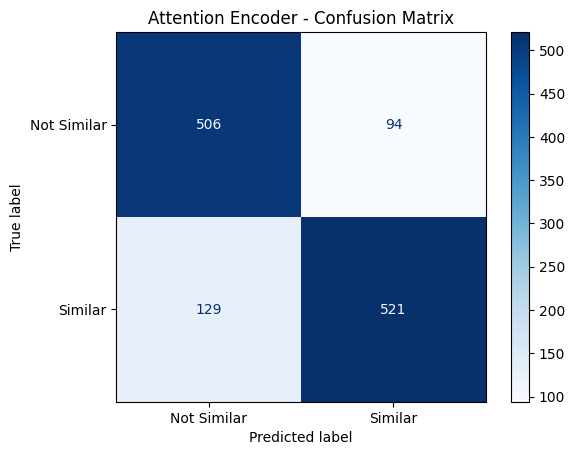

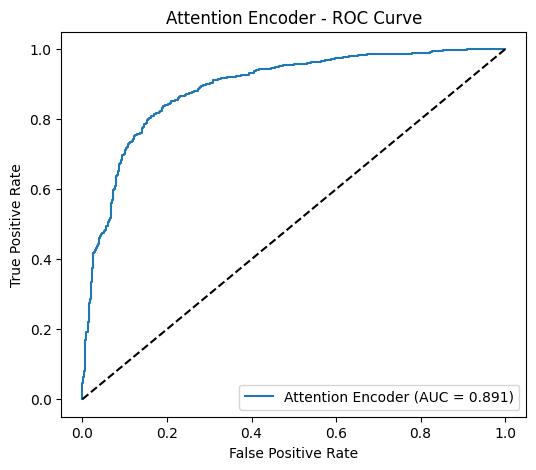

{'Accuracy': 0.8216,
 'Precision': 0.8471544715447155,
 'Recall': 0.8015384615384615,
 'F1': 0.8237154150197629,
 'ROC-AUC': np.float64(0.8907435897435898)}

In [44]:
evaluate_model(attn_model, X1_test, X2_test, y_test, "Attention Encoder")

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step

Evaluation Results for BiLSTM Model:
Accuracy  : 0.9816
Precision : 0.9831
Recall    : 0.9815
F1-Score  : 0.9823
ROC-AUC   : 0.9973


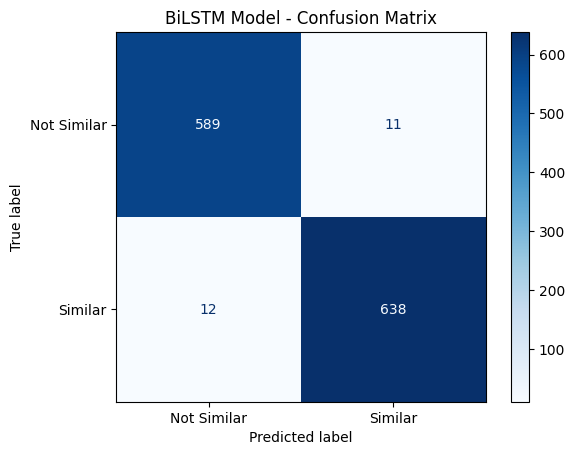

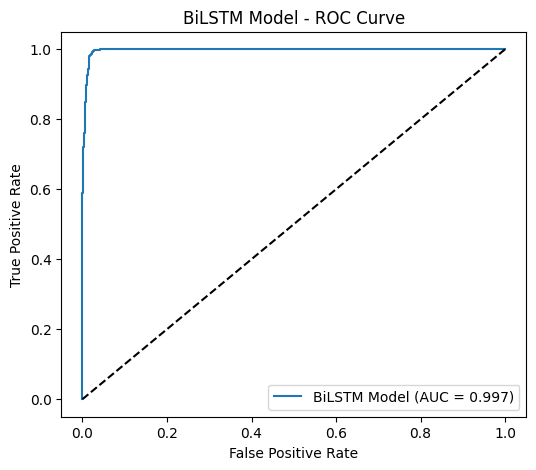

{'Accuracy': 0.9816,
 'Precision': 0.9830508474576272,
 'Recall': 0.9815384615384616,
 'F1': 0.9822940723633564,
 'ROC-AUC': np.float64(0.9972538461538462)}

In [48]:
evaluate_model(model, X1_test, X2_test, y_test, "BiLSTM Model")